# Hackathon prompt: Deep generative modeling of galaxy images
### IAIFI Summer School 2022

**Siddharth Mishra-Sharma** (smsharma@mit.edu)

## 1. Introduction

As part of one of the tutorials we trained a simple convolutional variational autoencoder (VAE) on the MNIST dataset. VAEs belong to a class of statistical methods called _generative models_ (in particular, a subclass of these called _latent variable models_) which model the distribution of data $x\sim p(x)$ (or possibly the joint data-label distribution $x, \theta \sim p(x,\theta)$). This is sometimes contrasted with _discriminative models_ commonly employed for classification or regression tasks, which model the conditional distribution of labels, $\theta \sim p(\theta\mid x)$.

The landscape of generative models is vast (e.g., GANs, VAEs, autoregressive models and, more recently, diffusion models to name a few) and the their theory as well as application are exciting areas research. Indeed, the recent large text-to-image models all use generative models of various flavours (DALL-E and Imagen use diffusion models, while Parti uses autoregressive models). Generative models have also proved effective in fundamental physics applications for modeling complex data distributions. We saw in the tutorials how a generative model of a non-trivial data distribution can be included as part of a physically-motivated probabilistic model for modeling astrophysical observations. Recent example applications of generative models in physics include [sampling from complex, symmetry-constrained distributions for lattice QCD](https://arxiv.org/abs/2101.08176), [detecting anomalous new physics](https://arxiv.org/abs/2109.00546) [in collider datasets](https://arxiv.org/abs/2011.03550), and [fast emulation of](https://arxiv.org/abs/2206.11898) [collider observations](https://arxiv.org/abs/2110.11377).

## 2. Prompt

- Train and evaluate deep generative models of your choice on a sample of real galaxy images (dataset details below). 
- Given the huge number of models available, feel free to look around for implementations in a framework (PyTorch/Jax/TF etc) that you're comfortable with.
- If working in a group, different people could try different classes of generative models.
- Think about ways of evaluating the quality of the learned model. Visual fidelity of generated samples could be one, but maybe also something more quantitative?

## 3. Resources and code

### 3.1 Theory
- Figure 1 of [this blog post by Lilian Weng](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) on diffusion models gives a visual taxonomy of some popular deep generative models.
    - [Post](https://lilianweng.github.io/posts/2018-10-13-flow-models/) on normalizing flows.
- [Jakub Tomczak's blog](https://jmtomczak.github.io/blog.html) is a great resource for explanations as well as code snippets of some generative models.

### 3.2 Example codes/implementations
- [The UvA Deep Learning Tutorials](https://uvadlc-notebooks.readthedocs.io/en/latest/) contain detailed hands-on tutorials on normalizing flows for images (in PyTorch and Jax) as well as autoregressive image models (in PyTorch).
- [Implementation](https://github.com/lucidrains/denoising-diffusion-pytorch) of a denoising diffusion model in PyTorch.
- [Normalizing flow implementations](https://github.com/VincentStimper/normalizing-flows) with example notebooks. Look out specifically for flows designed for modeling images.
- This [code repository](https://github.com/jmtomczak/intro_dgm) contains simple implementations of some popular models in PyTorch.
- [Implementation](https://github.com/VMBoehm/PAE) of a probabilistic auto-encoder including an example notebook.

### 3.3. Recent papers on generative modeling of galaxy images
Recent papers on generative modeling of galaxy images:
- [1910.06157](https://arxiv.org/abs/1910.06157): Uses a VAE model of COSMOS galaxies (below) in a probabilistic programming model.
- [2008.03833](https://arxiv.org/abs/2008.03833): Deep generative models for galaxy image simulations.
- [2111.01713](https://arxiv.org/abs/2111.01713): Deep generative models of galaxies with a diffusion model.
- [2203.11956](https://arxiv.org/abs/2203.11956): A comparison of a few deep generative modeling approaches.

## 4. Dataset and pre-processing

We will use the [COSMOS galaxy dataset](https://zenodo.org/record/3242143) observed by a _Hubble_ Space Telescopy [survey](https://cosmos.astro.caltech.edu/page/hst). A training sample can be downloaded from [here](https://zenodo.org/record/3242143); It's 4.4G in size, so could take a bit of time to download. The code block below should download and untar it, but probably better to do this part manually.

In [1]:
# import os
# import urllib.request

# # Download
# url = 'https://zenodo.org/record/3242143/files/COSMOS_23.5_training_sample.tar.gz?download=1'
# os.makedirs("./data", exist_ok=True)
# urllib.request.urlretrieve(url, './data/COSMOS_23.5_training_sample.tar.gz')

# # Untar
# os.system("tar -xvf ./data/COSMOS_23.5_training_sample.tar.gz")

Next we'll open and start processing the dataset.

In [2]:
from pathlib import Path
from PIL import Image

from astropy.io import fits
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
# Path to COSMOS dataset
catalog_folder = Path("data/COSMOS_23.5_training_sample/")

In [4]:
# Combine the 57 catalogs into a single array

galaxy_images = []

catalogs = catalog_folder.glob("real_galaxy_images_23.5_n*.fits")

for catalog in tqdm(catalogs):
    for galaxies in fits.open(catalog):
        galaxy_images.append(galaxies.data)

The images are of different sizes and aspect ratios. We'll crop them and downsample them to make them easier to work with.

In [5]:
n_xy = 64  # Number of pixels to downsample the image to

galaxy_images_cropped_downsampled = []

# Loop over all images, crop and downsample
for idx, galaxy_image in enumerate(tqdm(galaxy_images)):
    
    im = Image.fromarray(galaxy_image)
    
    ## Cropping
    
    width, height = galaxy_image.shape

    new_dim = np.min([width, height])
    
    # If the image is smaller than the minimum downsampled dimension, skip it
    if new_dim < n_xy:
        continue

    left = (width - new_dim) / 2
    top = (height - new_dim) / 2
    right = width - np.ceil((width - new_dim) / 2)
    bottom =  height - np.ceil((height - new_dim) / 2)

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    
    # Resize/downsample the image
    im = np.array(im.resize((n_xy, n_xy)))
    
    # Append cropped and downsampled image to list
    galaxy_images_cropped_downsampled.append(im)
    
galaxy_images_cropped_downsampled = np.array(galaxy_images_cropped_downsampled)

In [6]:
# # Save
# np.save("./data/galaxy_images_cropped_downsampled.npy", galaxy_images_cropped_downsampled)
# galaxy_images_cropped_downsampled = np.load("./data/galaxy_images_cropped_downsampled.npy")

Plot a random sample of images.

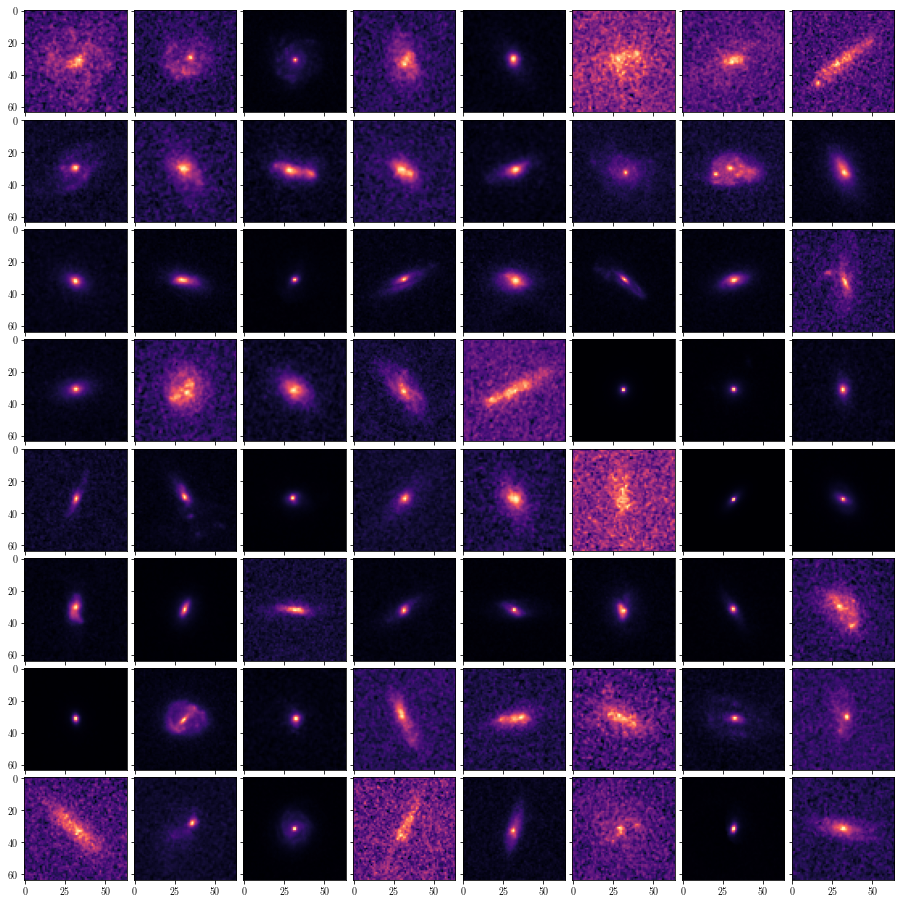

In [8]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(8, 8),axes_pad=0.1,)

for ax, im in zip(grid, galaxy_images_cropped_downsampled[np.random.randint(len(galaxy_images_cropped_downsampled), size=64)]):
    ax.imshow(im, cmap='magma')

It can be seen that many of the images are quite noisy and you may want to impose a cut based on some heuristic measure of the signal-to-noise ratio in order to exclude these since they may degrade training and the quality of the model.

In [9]:
# Number of processed images passing cuts
len(galaxy_images_cropped_downsampled)

45560